# Survival Analysis with lifelines Python

## An introduction to survival analysis with Python lifelines library

In this notebook, we go through the examples described in the `lifeline` python library [documentation](http://lifelines.readthedocs.io/en/latest/index.html) and explore the use of such librery modules.

Date: December 2017

Autor: [Alvaro Calle Cordon](www.linkedin.com/in/alvarocallecordon)

Notebook uses Python 2.7

## Setups

In [1]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Show in-line plots
%matplotlib inline

np.random.seed(0)

In [2]:
print(plt.style.available)

[u'seaborn-darkgrid', u'Solarize_Light2', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'_classic_test', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'fast', u'seaborn-pastel', u'seaborn-dark', u'seaborn', u'seaborn-dark-palette']


In [3]:
# Set default styles for plotting
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6

## Quickstart

### Kaplan-Meier and Nelson-Aalen

In [4]:
from lifelines.datasets import load_waltons
df = load_waltons() # returns a Pandas DataFrame

print(df.head())

T = df['T'] # durations
E = df['E'] # censorship

      T  E    group
0   6.0  1  miR-137
1  13.0  1  miR-137
2  13.0  1  miR-137
3  13.0  1  miR-137
4  19.0  1  miR-137


KM estimator

In [5]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)  # or, more succiently, kmf.fit(T, E)

<lifelines.KaplanMeierFitter: fitted with 163 observations, 7 censored>

Fit results

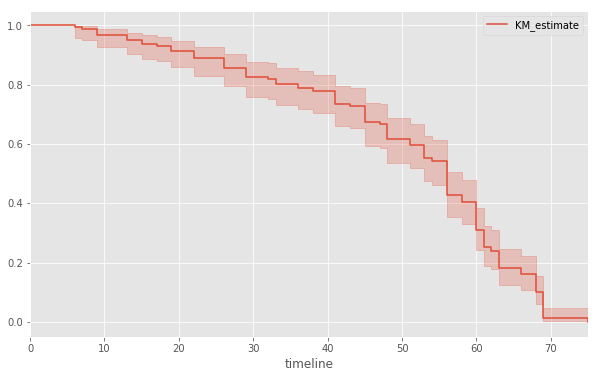

In [6]:
kmf.survival_function_
kmf.median_
kmf.plot()

### Multiple groups

There are two groups in the data set:

In [7]:
print df.group.unique()

['miR-137' 'control']


#### Kaplan-Meier

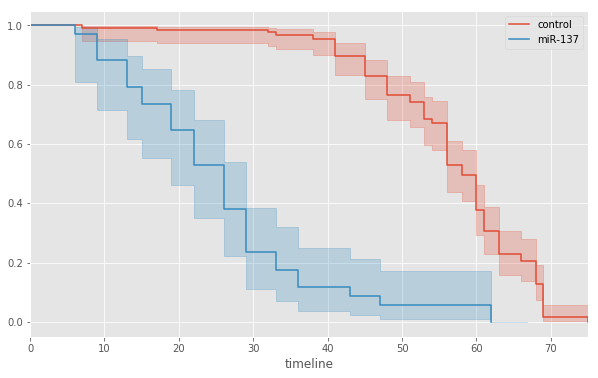

In [8]:
groups = df['group']
ix = (groups == 'miR-137')

# fit control group
kmf.fit(T[~ix], E[~ix], label='control')
ax = kmf.plot()

# fit miR-137 group
kmf.fit(T[ix], E[ix], label='miR-137')
kmf.plot(ax=ax)

#### Nelson-Aalen

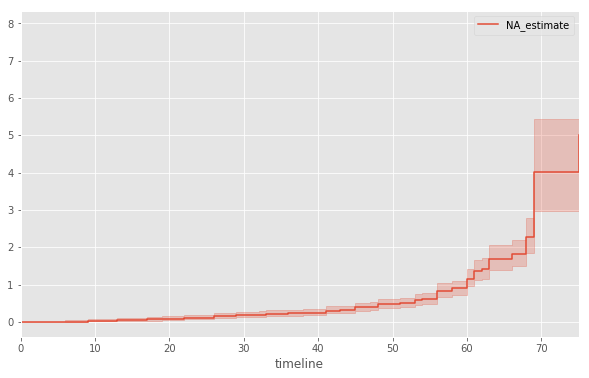

In [9]:
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()
naf.fit(T, event_observed=E)
naf.cumulative_hazard_
naf.plot()

**Observation:** 

Similar to Scikit-Learn, all statistically estimated quantities append an underscore to the property name.

### Getting Data in The Right Format

- From date_times to durations: *start_time, end_time* $\to$ *durations*

In [10]:
from lifelines.utils import datetimes_to_durations

# start_times is a vector of datetime objects
# end_times is a vector of (possibly missing) datetime objects.
T, E = datetimes_to_durations(start_times, end_times, freq='h')

NameError: name 'start_times' is not defined

- Survival table given some durations and censorship vectors.

In [11]:
from lifelines.utils import survival_table_from_events

table = survival_table_from_events(T, E)
print(table.head())

          removed  observed  censored  entrance  at_risk
event_at                                                
0.0             0         0         0       163      163
6.0             1         1         0         0      163
7.0             2         1         1         0      162
9.0             3         3         0         0      160
13.0            3         3         0         0      157


### Survival Regression

Event data including covariates

In [12]:
from lifelines.datasets import load_regression_dataset
regression_dataset = load_regression_dataset()

regression_dataset.head()

,var1,var2,var3,T,E
0,0.595170,1.143472,1.571079,14.785479,1
1,0.209325,0.184677,0.356980,7.336734,1
2,0.693919,0.071893,0.557960,5.271527,1
3,0.443804,1.364646,0.374221,11.684168,1
4,1.613324,0.125566,1.921325,7.637764,1


The input of the fit method's API in a regression is different. All the data, including durations, censorships and covariates must be contained in a Pandas DataFrame. The duration column and event occured column must be specified in the call to fit.

If $\beta$ is a vector of coefficients and $\mathbf X = (x_1, \ldots, x_n)$ a vector of $n$ covariates (for a single instance), there are two popular competing techniques in survival regression: Cox's model and Aalen's additive model. Both models attempt to represent the **hazard rate** $\lambda(t|x)$ as a function of $t$ and some covariates $x$:

- CoxPH: $\lambda(t|\mathbf{X}) = \lambda_0(t)\ \exp{(- \mathbf \beta^T \mathbf X)}$

n=200, number of events=189

       coef  exp(coef)  se(coef)      z      p  lower 0.95  upper 0.95    
var1 0.2213     1.2476    0.0743 2.9784 0.0029      0.0756      0.3669  **
var2 0.0509     1.0522    0.0829 0.6136 0.5395     -0.1116      0.2134    
var3 0.2185     1.2442    0.0758 2.8824 0.0039      0.0699      0.3672  **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.580


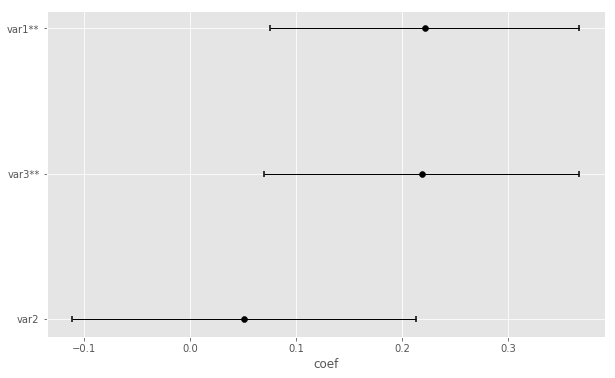

In [13]:
from lifelines import CoxPHFitter

# Using Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(regression_dataset, 'T', event_col='E')
cph.print_summary()
cph.plot()

- Aalen's Additive model:  $\lambda(t|\mathbf{X}) = \lambda_0(t) + \mathbf \beta(t)^T \mathbf X$

 [-----------------100%-----------------] 189 of 189 complete in 0.2 sec


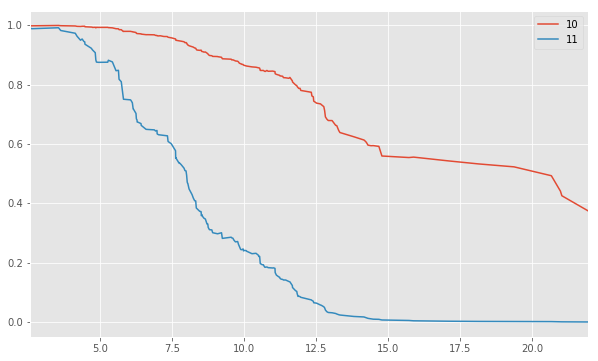

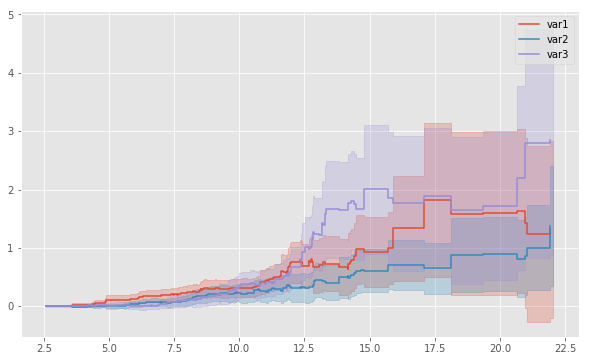

In [14]:
from lifelines import AalenAdditiveFitter
aaf = AalenAdditiveFitter(fit_intercept=False)
aaf.fit(regression_dataset, 'T', event_col='E')

X = regression_dataset.drop(['E', 'T'], axis=1)
aaf.predict_survival_function(X.iloc[10:12]).plot()  # get the unique survival functions of two subjects

aaf.plot()

## Introduction to Survival Analysis

### Concept of censorship

Consider a case where the population is actually made up of two subpopulations, A and B. Population A has a very small lifespan, say 2 months on average, and population B enjoys a much larger lifespan, say 12 months on average. We might not know this distinction before hand. At $t=10$, we wish to investigate the average lifespan. Below is an example of such a situation.

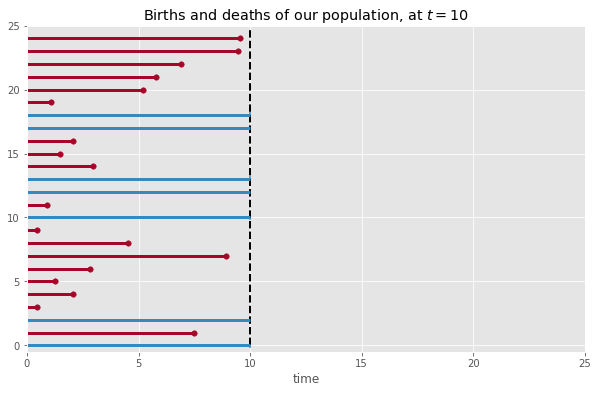

('Observed lifetimes at time 10:\n', array([  9.5504941 ,   9.44641383,   6.90623039,   5.80322521,
         5.19650831,   1.09393235,  10.        ,  10.        ,
         2.04286377,   1.47565456,   2.97650968,  10.        ,
        10.        ,   0.89103699,  10.        ,   0.47241341,
         4.54754359,   8.90899476,   2.81161819,   1.25588316,
         2.07752943,   0.43776121,  10.        ,   7.4980629 ,  10.        ]))


In [16]:
from lifelines.plotting import plot_lifetimes
from numpy.random import uniform, exponential
import matplotlib.pyplot as plt

N = 25
current_time = 10
actual_lifetimes = np.array([[exponential(12), exponential(2)][uniform() < 0.5] for i in range(N)])
observed_lifetimes = np.minimum(actual_lifetimes, current_time)
observed = actual_lifetimes < current_time

plt.xlim(0, 25)
plt.vlines(10, 0, 30, lw=2, linestyles='--')
plt.xlabel("time")
plt.title("Births and deaths of our population, at $t=10$")
plot_lifetimes(observed_lifetimes, event_observed=observed)
print("Observed lifetimes at time %d:\n" % (current_time), observed_lifetimes)

- Red lines denote the lifespan of individuals where the death event has been observed
- Blue lines denote the lifespan of the right-censored individuals (deaths have not been observed). 

> If we are asked to estimate the average lifetime of our population, and we naively decided to not included the right-censored individuals, it is clear that we would be serverly underestimating the true average lifespan:

In [17]:
# Mean lifetime ignoring right-censored data
observed_lifetimes[(observed_lifetimes < 10)].mean()

4.0773708795323245

> Furthermore, if we instead simply took the mean of all observed lifespans, including the current lifespans of right-censored instances, we would still be underestimating the true average lifespan:

In [18]:
# Mean lifetime including current lifespams of right-censored data
observed_lifetimes.mean()

5.7357070332632727

Why? Below we plot the actual lifetimes of all instances (recall, in practice, we do not see this information at t=10).

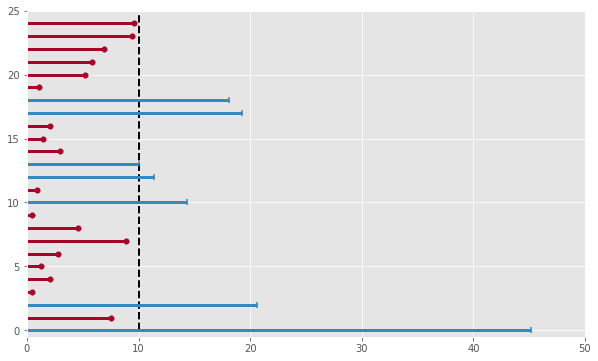

In [19]:
plt.xlim(0,50)
plt.vlines(10, 0, 30, lw=2, linestyles='--')
plot_lifetimes(actual_lifetimes, event_observed=observed)

Survival analysis was originally developed to solve this type of problem, that is, to deal with estimation when our data is right-censored. Even in the case where all events have been observed, i.e. no censorship, survival analysis is still a very useful tool to understand durations.

The observations need not always start at zero, either. This is called left-censoring.

We next introduce the two fundamental objects in survival analysis, the **survival function** and the **hazard function**.

### Survival function

Let $T$ be a (possibly infinite, but always non-negative) random lifetime taken from the population under study. For example, the amount of time a couple is married. Or the time it takes a user to enter a webpage (an infinite time if they never do). The survival function - $S(t)$ - of a population is defined as

$$
S(t) = \text{Pr}(T > t)
$$

In plain English: the survival function defines the probability the death event has not occured yet at time $t$, or equivalently, the probability of surviving past time t. Note the following properties of the survival function:

- $ 0 \leq S(t) \leq 1$
- $F_T(t) = 1 − S(t)$, where $F_T(t)$ is the CDF of $T$, which implies
- $S(t)$ is a non-increasing function of $t$.

### Hazard function

We are also interested in the probability of the death event occurring at time $t$, given that the death event has not occurred until time t. Mathematically, that is:

$$
\lim_{\delta t\to 0} \text{Pr}(t\leq T \leq t + \delta t\ |\ T>t)
$$

This quantity goes to 0 as $\delta t$ shrinks, so we divide this by the interval $\delta t$ (like we might do in calculus). This defines the hazard function at time $t$, $\delta (t)$:

$$
\lambda(t)=\lim_{\delta t \to 0} \frac{\text{Pr}(t \leq T \leq t + \delta t\ |\ T>t)}{t}
$$

It can be shown with quite elementary probability that this is equal to:

$$
\lambda(t) = -\frac{S'(t)}{S(t)}
$$

and solving this differential equation, we get:

$$
S(t) = \exp{(−\int_0^t \lambda(z)\ dz)}
$$

The above equation defines all survival functions, in terms of an arbitrary hazard function (i.e. there is no parametric form) and this allows for very flexible curves. Notice that we can now speak either about the survival function, $S(t)$, or the hazard function, $\lambda(t)$, and we can convert back and forth quite easily. It also gives us another, albeit less useful, expression for $T$:

$$
f_T(t)=\lambda(t)  \exp{(−\int_0^t \lambda(z)\ dz)}
$$

Because we do not observe the true survival curve of a population, we must use the observed data to estimate it (either parametric or non-parametrically):

- The **Kaplan-Meier** estimator is a non-parametric estimator of the survival function, and,
- The **Nelson-Aalen** estimator is a non-parametric estimator of the (cumulative) hazard function.

## Survival analysis with lifelines

### Estimating the Survival function using Kaplan-Meier

#### Data

For this example, we will be investigating the lifetimes of political leaders around the world. A political leader in this case is defined by a single individual's time in office who controls the ruling regime. This could be an elected president, unelected dictator, monarch, etc. The birth event is the start of the individual's tenure, and the death event is the retirement of the individual. Censorship can occur if they are a) still in offices at the time of dataset complilation (2008), or b) die while in office (this includes assassinations).

For example, the Bush regime began in 2000 and officially ended in 2008 upon his retirement, thus this regime's lifespan was 8 years and the "death" event was observed. On the other hand, the JFK regime lasted 2 years, from 1961 and 1963, and the regime's official death event was not observed - JFK died before his official retirement.

To estimate the survival function, we use the Kaplan-Meier Estimate:

In [20]:
import pandas as pd
from lifelines.datasets import load_dd

data = load_dd()

data.sample(6)

,ctryname,cowcode2,politycode,un_region_name,un_continent_name,ehead,leaderspellreg,democracy,regime,start_year,duration,observed
1010,Malta,338,338.0,Southern Europe,Europe,Dominic Mintoff,Dominic Mintoff.Malta.1971.1983.Parliamentary Dem,Democracy,Parliamentary Dem,1971,13,1
979,Madagascar,580,580.0,Eastern Africa,Africa,Didier Ratsiraka,Didier Ratsiraka.Madagascar.1975.1992.Military...,Non-democracy,Military Dict,1975,18,1
84,Austria,305,305.0,Western Europe,Europe,Alfred Gusenbauer,Alfred Gusenbauer.Austria.2007.2008.Mixed Dem,Democracy,Mixed Dem,2007,2,0
1798,Yugoslavia,345,345.0,Southern Europe,Europe,Stipe Suvar,Stipe Suvar.Yugoslavia.1988.1988.Civilian Dict,Non-democracy,Civilian Dict,1988,1,1
220,Bulgaria,355,355.0,Eastern Europe,Europe,Todor Zhivkov,Todor Zhivkov.Bulgaria.1954.1988.Civilian Dict,Non-democracy,Civilian Dict,1954,35,1
135,Belize,80,80.0,Central America,Americas,George Cadle Price,George Cadle Price.Belize.1981.1983.Parliament...,Democracy,Parliamentary Dem,1981,3,1


The DataFrame contains a column of `duration` and a boolean variable `observed` refers to whether the death (leaving office) was observed or not.

In [21]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [22]:
#KaplanMeierFitter.fit?

In [23]:
T = data["duration"]
E = data["observed"]

kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter: fitted with 1808 observations, 340 censored>

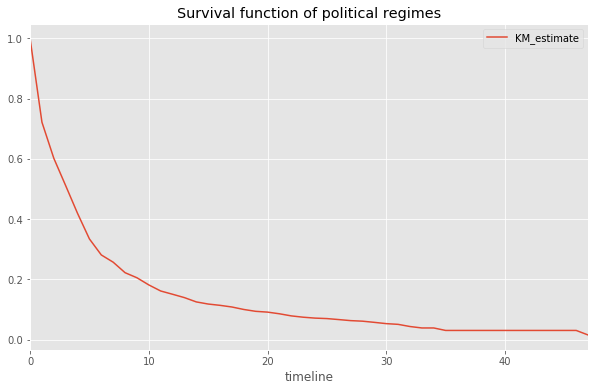

In [24]:
kmf.survival_function_.plot()
plt.title('Survival function of political regimes');

How do we interpret this figure? The y-axis represents the probability a leader is still around after t years, where t years is on the x-axis. We see that very few leaders make it past 20 years in office. Of course, like all good stats, we need to report how uncertain we are about these point estimates, i.e. we need confidence intervals. They are computed in the call to fit, and are located under the confidence_interval_property. 

Alternatively, we can call plot on the KaplanMeierFitter itself to plot both the KM estimate and its confidence intervals:

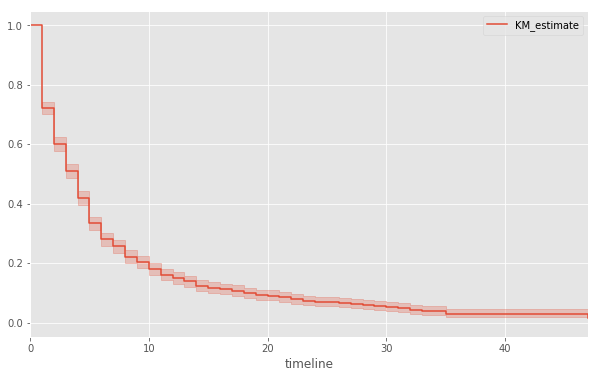

In [25]:
kmf.plot()

Convert to a Plotly object:

In [26]:
# The median time in office (point in time where on average 1/2 of the population has expired):
kmf.median_

4.0

Interesting that it is only 4 years. That means, around the world, when a leader is elected there is a 50% chance he or she will be gone in 4 years!

Let's segment on democratic regimes vs non-democratic regimes. Calling plot on either the estimate itself or the fitter object will return an axis object, that can be used for plotting further estimates:

('Median survival time of democratic:', 3.0)
('Median survival time of non-democratic:', 6.0)


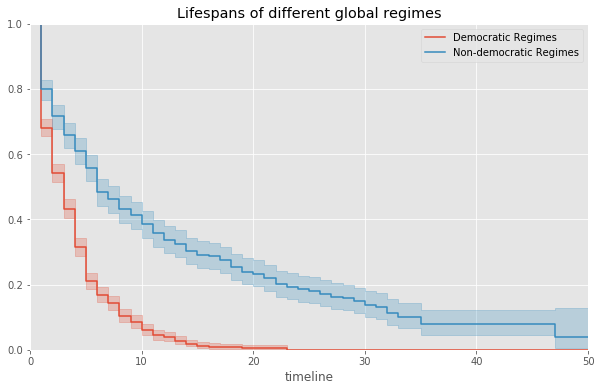

In [27]:
ax = plt.subplot(111)

t = np.linspace(0, 50, 51)

dem = (data["democracy"] == "Democracy")

kmf.fit(T[dem], event_observed=E[dem], timeline=t, label="Democratic Regimes")
ax = kmf.plot(ax=ax)
print("Median survival time of democratic:", kmf.median_)

kmf.fit(T[~dem], event_observed=E[~dem], timeline=t, label="Non-democratic Regimes")
ax = kmf.plot(ax=ax)
print("Median survival time of non-democratic:", kmf.median_)

plt.ylim(0,1)
plt.title("Lifespans of different global regimes");

It is incredible how much longer these non-democratic regimes exist for. A democratic regime does have a natural bias towards death though: both via elections and natural limits (the US imposes a strict 8 year limit). The median of a non-democractic is only a bit larger than a democratic regime, but the difference is really apparent in the tails: if you're a non-democratic leader, and you've made it past the 10 year mark, you probably have a long life ahead. Meanwhile, a democratic leader rarely makes it past 10 years, and then have a very short lifetime past that.

Here the difference between survival functions is very obvious, and performing a statistical test seems pedantic. If the curves are more similar, or we possess less data, we may be interested in performing a statistical test. In this case, lifelines contains routines in `lifelines.statistics` to compare two survival curves. Below we demonstrate this routine. The function `logrank_test` is a common statistical test in survival analysis that compares two event series' generators. If the value returned exceeds some prespecified value, then we rule that the series have different generators.

In [28]:
from lifelines.statistics import logrank_test

results = logrank_test(T[dem], T[~dem], E[dem], E[~dem], alpha=.99)

results.print_summary()

Results
   df: 1
   alpha: 0.99
   t 0: -1
   test: logrank
   null distribution: chi squared

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00000 |            260.470 |      Reject Null    |        True       


Lets compare the different types of regimes present in the dataset:

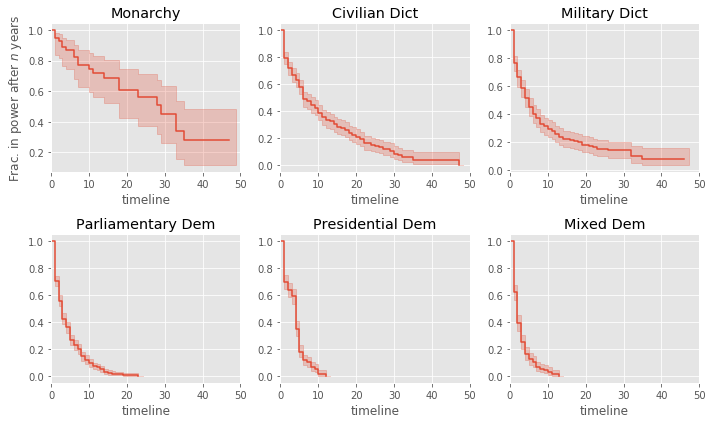

In [29]:
regime_types = data['regime'].unique()

for i,regime_type in enumerate(regime_types):
    ax = plt.subplot(2, 3, i+1)
    ix = data['regime'] == regime_type
    kmf.fit( T[ix], E[ix], label=regime_type)
    kmf.plot(ax=ax, legend=False)
    plt.title(regime_type)
    plt.xlim(0, 50)
    if i==0:
        plt.ylabel('Frac. in power after $n$ years')

plt.tight_layout()

#### Getting data into the right format

Lifelines data format is consistent across all estimator class and functions: an array of individual durations, and the individuals event observation (if any). These are often denoted T and E respectively. For example:

In [31]:
T = [0,3,3,2,1,2]
E = [1,1,0,0,1,1]
kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter: fitted with 6 observations, 2 censored>

The raw data is not always available in this format - lifelines includes some helper functions to transform data formats to lifelines format. These are located in the `lifelines.utils` sublibrary. For example, the function `datetimes_to_durations` accepts an array or Pandas object of start times/dates, and an array or Pandas objects of end times/dates (or None if not observed):

In [32]:
from lifelines.utils import datetimes_to_durations

start_date = ['2013-10-10 0:00:00', '2013-10-09', '2013-10-10']
end_date = ['2013-10-13', '2013-10-10', None]
T, E = datetimes_to_durations(start_date, end_date, fill_date='2013-10-15')
print('T (durations): ', T)
print('E (event_observed): ', E)

('T (durations): ', array([ 3.,  1.,  5.]))
('E (event_observed): ', array([ True,  True, False], dtype=bool))


#### Fitting to a Weibull model

A very popular model for reliability data is the Weibull model. In contrast the the Kaplan-Meier estimator, this model is a parametric model, meaning it has a functional form with parameters that we are fitting the data to. In lifelines, this is implemented in the WeibullFitter:

(0.16366017864643498, 0.94264634310995588)
n=1808, number of events=1468

             coef  se(coef)  lower 0.95  upper 0.95
lambda_ 1.637e-01 4.603e-03   1.546e-01   1.727e-01
rho_    9.426e-01 1.799e-02   9.074e-01   9.779e-01


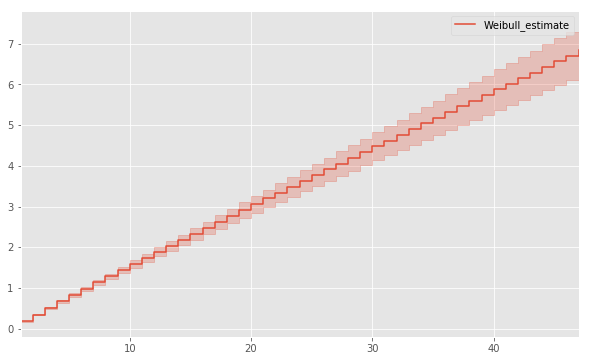

In [35]:
from lifelines import WeibullFitter

T = data['duration']
E = data['observed']

wf = WeibullFitter()
wf.fit(T, E)
print(wf.lambda_, wf.rho_)
wf.print_summary()
wf.plot_cumulative_hazard()

### Estimating hazard rates using the Nelson-Aalen

The survival curve is a great way to summarize and visualize the lifetime data, however it is not the only way. If we are curious about the hazard function $\lambda(t)$ of a population, we unfortunately cannot transform the Kaplan Meier estimate. Fortunately, there is a proper estimator of the cumulative hazard function:

$$
\Lambda(t) = \int_0^t \ \lambda(z)\ dz
$$

The estimator for this quantity is called the Nelson-Aalen estimator:

$$
\hat\Lambda(t) = \sum_{t_i\leq t} \frac{d_i}{n_i}
$$

where $d_i$ is the number of deaths at time $t_i$ and $n_i$ is the number of susceptible individuals.

In [37]:
T = data["duration"]
E = data["observed"]

from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()

naf.fit(T,event_observed=E)

<lifelines.NelsonAalenFitter: fitted with 1808 observations, 340 censored>

          NA_estimate
timeline             
0.0          0.000000
1.0          0.325912
2.0          0.507356
3.0          0.671251
4.0          0.869867


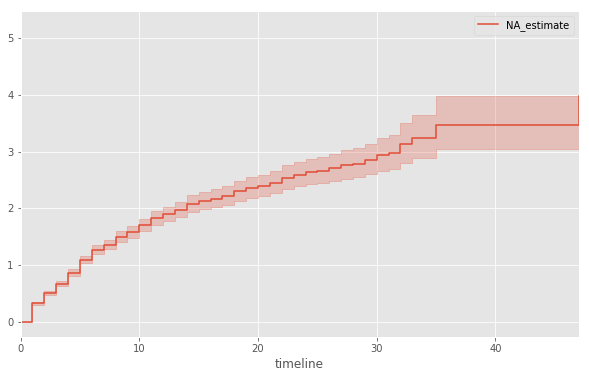

In [38]:
print(naf.cumulative_hazard_.head())
naf.plot()

The rate of change of the curve above is an estimate of the hazard function. Looking at figure above, it looks like the hazard starts off high and gets smaller (as seen by the decreasing rate of change). Let's break the regimes down between democratic and non-democratic, during the first 20 years:

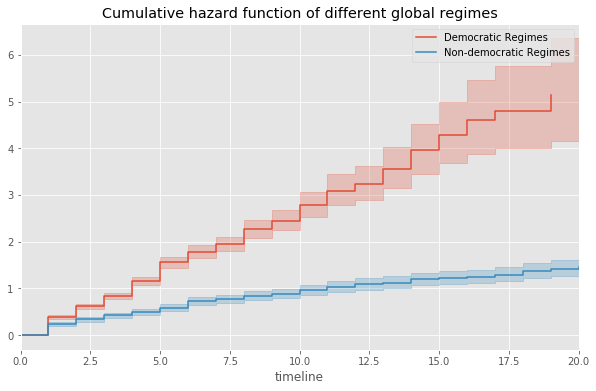

In [39]:
naf.fit(T[dem], event_observed=E[dem], label="Democratic Regimes")
ax = naf.plot(loc=slice(0, 20))
naf.fit(T[~dem], event_observed=E[~dem], label="Non-democratic Regimes")
naf.plot(ax=ax, loc=slice(0, 20))
plt.title("Cumulative hazard function of different global regimes");

Looking at the rates of change, we can say that both political philosophies have a constant hazard, albeit democratic regimes have a much higher constant hazard. So why did the combination of both regimes have a decreasing hazard? This is the effect of **frailty**, a topic we will discuss later.

#### Smoothing the hazard curve

Interpretation of the cumulative hazard function can be difficult. Alternatively, we can derive the more-interpretable hazard curve, but there is a catch. The derivation involves a kernel smoother (to smooth out the differences of the cumulative hazard curve), and this requires us to specify a bandwidth parameter that controls the amount of smoothing. This functionality is provided in the `smoothed_hazard_` and `hazard_confidence_intervals_` methods.

There is also a `plot_hazard` function (that also requires a bandwidth keyword) that will plot the estimate plus the confidence intervals, similar to the traditional plot functionality.

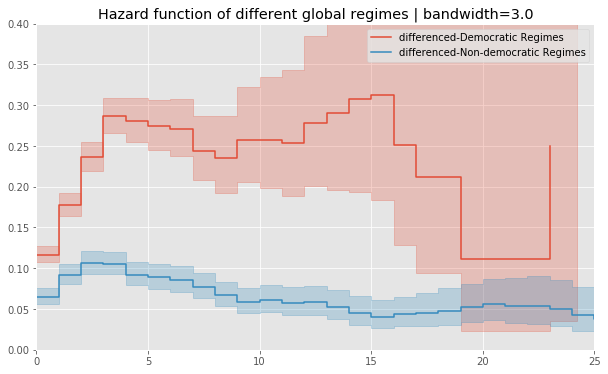

In [40]:
b = 3.
naf.fit(T[dem], event_observed=E[dem], label="Democratic Regimes")
ax = naf.plot_hazard(bandwidth=b)
naf.fit(T[~dem], event_observed=E[~dem], label="Non-democratic Regimes")
naf.plot_hazard(ax=ax, bandwidth=b)
plt.title("Hazard function of different global regimes | bandwidth=%.1f"%b);
plt.ylim(0, 0.4)
plt.xlim(0, 25);

There is no obvious way to choose a bandwidth, and different bandwidths can produce different inferences, so best to be very careful here. **(advice: stick with the cumulative hazard function.)**

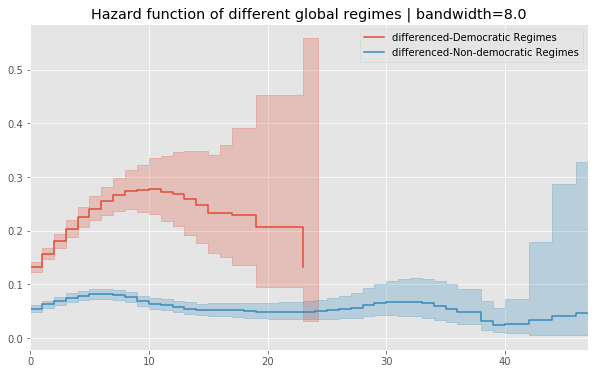

In [41]:
b = 8.
naf.fit(T[dem], event_observed=E[dem], label="Democratic Regimes")
ax = naf.plot_hazard(bandwidth=b)
naf.fit(T[~dem], event_observed=E[~dem], label="Non-democratic Regimes")
naf.plot_hazard(ax=ax, bandwidth=b)
plt.title("Hazard function of different global regimes | bandwidth=%.1f"%b);

### Other types of censorship

#### Left Censored Data

There are situations where we do not observe the birth event occurring, and this is called left-censored data. `lifelines` has support for left-censored datasets in the `KaplanMeierFitter` class, by adding the keyword `left_censorship=True` (default False) to the call to fit.

In [45]:
from lifelines.datasets import load_lcd
lcd_dataset = load_lcd()

ix = lcd_dataset['group'] == 'alluvial_fan'

T = lcd_dataset[ix]['T']
E = lcd_dataset[ix]['C'] #boolean array, True if observed.

kmf = KaplanMeierFitter()
kmf.fit(T, E, left_censorship=True)

<lifelines.KaplanMeierFitter: fitted with 55 observations, 12 censored>

          KM_estimate
timeline             
0.0          0.087646
1.0          0.197203
2.0          0.657343
3.0          0.788811
4.0          0.854545
5.0          0.909091
7.0          0.963636
8.0          0.981818
9.0          1.000000


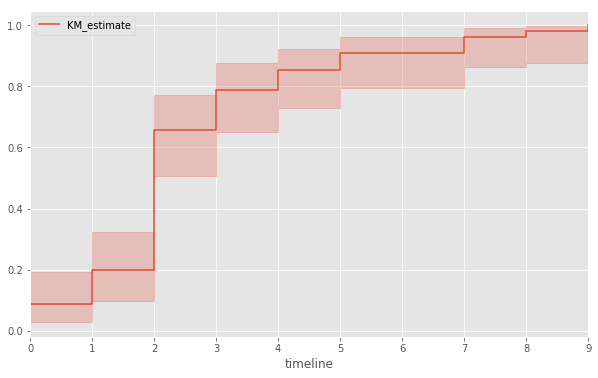

In [46]:
print(kmf.cumulative_density_)
kmf.plot() #will plot the CDF

#### Left Truncated Data

Another form of bias that can be introduced into a dataset is called left-truncation. (Also a form of censorship). This occurs when individuals may die even before ever entering into the study. Both `KaplanMeierFitter` and `NelsonAalenFitter` have an optional arugment for entry, which is an array of equal size to the duration array. It describes the offset from birth to entering the study. This is also useful when subjects enter the study at different points in their lifetime. For example, if you are measuring time to death of prisoners in prison, the prisoners will enter the study at different ages.

> Other types of censorship, like interval-censorship, are not implemented in lifelines yet.

## Survival Regression

### Aalen’s Additive model (experimental implementation)

**Data**: For this example, we will use the regime dataset and include the categorical variables `un_continent_name` (eg: Asia, North America, ...), the `regime` type (eg: monarchy, civilan, ...) and the year the regime started in, `start_year`.

Aalen's additive model typically does not estimate the individual $b_i(t)$ but instead estimates $\int_0^t b_i(s)ds$ (similar to the estimate of the hazard rate using `NelsonAalenFitter` above). This is important to keep in mind when analzying the output

In [47]:
from lifelines import AalenAdditiveFitter
data.head()

,ctryname,cowcode2,politycode,un_region_name,un_continent_name,ehead,leaderspellreg,democracy,regime,start_year,duration,observed
0,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1946.1952.Mona...,Non-democracy,Monarchy,1946,7,1
1,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1953.1962.Ci...,Non-democracy,Civilian Dict,1953,10,1
2,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1963.1972.Mona...,Non-democracy,Monarchy,1963,10,1
3,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1973.1977.Ci...,Non-democracy,Civilian Dict,1973,5,0
4,Afghanistan,700,700.0,Southern Asia,Asia,Nur Mohammad Taraki,Nur Mohammad Taraki.Afghanistan.1978.1978.Civi...,Non-democracy,Civilian Dict,1978,1,0


Create a design matrix with pasty

In [49]:
import patsy
# the '-1' term refers to not adding an intercept column (a column of all 1s).
X = patsy.dmatrix('un_continent_name + regime + start_year - 1', data, return_type='dataframe')
X.columns

Index([u'un_continent_name[Africa]', u'un_continent_name[Americas]',
       u'un_continent_name[Asia]', u'un_continent_name[Europe]',
       u'un_continent_name[Oceania]', u'regime[T.Military Dict]',
       u'regime[T.Mixed Dem]', u'regime[T.Monarchy]',
       u'regime[T.Parliamentary Dem]', u'regime[T.Presidential Dem]',
       u'start_year'],
      dtype='object')

Below we create our fitter class:

- Since we did not supply an intercept column in our matrix we have included the keyword `fit_intercept=True` (True by default) which will append the column of ones to our matrix. (Sidenote: the intercept term, $b_0(t)$ in survival regression is often referred to as the **baseline hazard**.)

- We have also included the `coef_penalizer` option. During the estimation, a linear regression is computed at each step. Often the regression can be unstable (due to high co-linearity or small sample sizes) - adding a penalizer term controls the stability. It is recommended always starting with a small penalizer term - if the estimates still appear to be too unstable, try increasing it.

In [52]:
aaf = AalenAdditiveFitter(coef_penalizer=1.0, fit_intercept=True)

X['T'] = data['duration']
X['E'] = data['observed']

aaf.fit(X, 'T', event_col='E')

 [-----------------100%-----------------] 1468 of 1468 complete in 1.1 sec


<lifelines.AalenAdditiveFitter: fitted with 1808 observations, 340 censored>

After fitting, the instance exposes a cumulative_hazards_ DataFrame containing the estimates of $\int_0^t b_i(s)ds$:

In [57]:
plt.figure(figsize=(12.5,8))
aaf.cumulative_hazards_.head()

,un_continent_name[Africa],un_continent_name[Americas],un_continent_name[Asia],un_continent_name[Europe],un_continent_name[Oceania],regime[T.Military Dict],regime[T.Mixed Dem],regime[T.Monarchy],regime[T.Parliamentary Dem],regime[T.Presidential Dem],start_year,baseline
1,-0.051595,-0.082406,0.010666,0.154493,-0.060438,0.075333,0.086274,-0.133938,0.048077,0.127171,0.000116,-0.029280
2,-0.014713,-0.039471,0.095668,0.194251,-0.092696,0.115033,0.358702,-0.226233,0.168783,0.121862,0.000053,0.143039
3,0.007389,-0.064758,0.115121,0.170549,0.069371,0.161490,0.677347,-0.271183,0.328483,0.146234,0.000004,0.297672
4,-0.058418,0.011399,0.091784,0.205824,0.125722,0.220028,0.932674,-0.294900,0.365604,0.422617,0.000002,0.376311
5,-0.099282,0.106641,0.112083,0.150708,0.091900,0.241575,1.123860,-0.391103,0.536185,0.743913,0.000057,0.362049


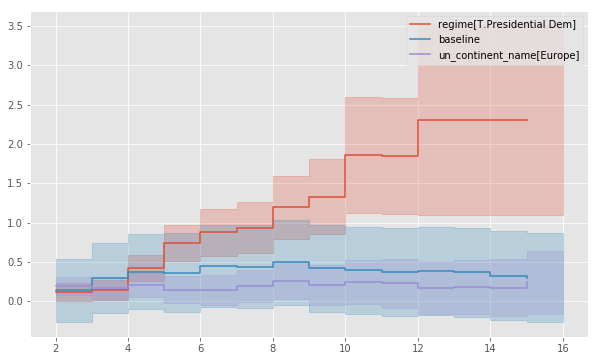

In [58]:
aaf.plot(columns=['regime[T.Presidential Dem]', 'baseline', 'un_continent_name[Europe]'], iloc=slice(1,15))

We can use what we have learned to predict individual hazard rates, survival functions, and median survival time. The dataset we are using is aviable up until 2008, so let's use this data to predict the (already partly seen) possible duration of Canadian Prime Minister Stephen Harper.

In [61]:
ix = (data['ctryname'] == 'Canada') * (data['start_year'] == 2006)
harper = X.loc[ix]
print("Harper's unique data point:")
harper

Harper's unique data point:


,un_continent_name[Africa],un_continent_name[Americas],un_continent_name[Asia],un_continent_name[Europe],un_continent_name[Oceania],regime[T.Military Dict],regime[T.Mixed Dem],regime[T.Monarchy],regime[T.Parliamentary Dem],regime[T.Presidential Dem],start_year,T,E
268,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2006.0,3,0


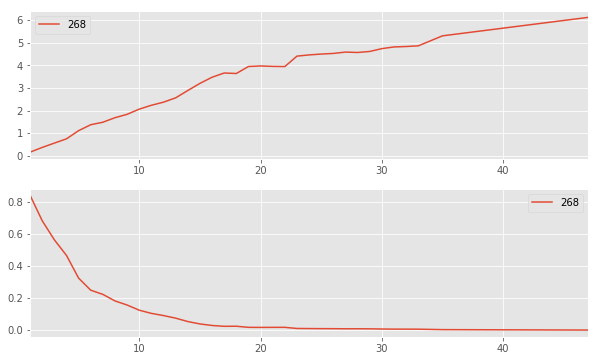

In [62]:
ax = plt.subplot(2,1,1)

aaf.predict_cumulative_hazard(harper).plot(ax=ax)
ax = plt.subplot(2,1,2)

aaf.predict_survival_function(harper).plot(ax=ax);

### Cox's Proportional Hazard model

#### Fit results

This model is of the form:

$$
\lambda(t|X) = b_0(t)\exp\left(\sum_{i=1}^d\ b_i\ x_i\right)
$$

Note a few facts about this model: the only time component is in the baseline hazard, $b_0(t)$. In the above product, the second term is only a scalar factor that only increases or decreases the baseline hazard. Thus a change in a covariate will only increase or decrease this baseline hazard.

In [63]:
from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter

rossi_dataset = load_rossi()
cph = CoxPHFitter()
cph.fit(rossi_dataset, duration_col='week', event_col='arrest')

cph.print_summary()  # access the results using cph.summary

n=432, number of events=114

        coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95    
fin  -0.3790     0.6846    0.1914 -1.9804 0.0477     -0.7541     -0.0038   *
age  -0.0572     0.9444    0.0220 -2.6037 0.0092     -0.1003     -0.0141  **
race  0.3141     1.3690    0.3080  1.0197 0.3079     -0.2897      0.9179    
wexp -0.1511     0.8598    0.2121 -0.7124 0.4762     -0.5670      0.2647    
mar  -0.4327     0.6488    0.3817 -1.1334 0.2570     -1.1810      0.3157    
paro -0.0850     0.9185    0.1957 -0.4341 0.6643     -0.4687      0.2988    
prio  0.0911     1.0954    0.0286  3.1819 0.0015      0.0350      0.1472  **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.640


In [66]:
print(cph.hazards_)
print(cph.baseline_hazard_.head())

           fin      age      race      wexp       mar      paro      prio
coef -0.378969 -0.05723  0.314081 -0.151108 -0.432673 -0.084965  0.091104
          baseline hazard
event_at                 
0.0              0.000000
1.0              0.001960
2.0              0.001966
3.0              0.001967
4.0              0.001971


#### Goodness of fit and prediction

**1) look at the concordance-index**:

In [73]:
cph.print_summary()

n=432, number of events=114

        coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95    
fin  -0.3790     0.6846    0.1914 -1.9804 0.0477     -0.7541     -0.0038   *
age  -0.0572     0.9444    0.0220 -2.6037 0.0092     -0.1003     -0.0141  **
race  0.3141     1.3690    0.3080  1.0197 0.3079     -0.2897      0.9179    
wexp -0.1511     0.8598    0.2121 -0.7124 0.4762     -0.5670      0.2647    
mar  -0.4327     0.6488    0.3817 -1.1334 0.2570     -1.1810      0.3157    
paro -0.0850     0.9185    0.1957 -0.4341 0.6643     -0.4687      0.2988    
prio  0.0911     1.0954    0.0286  3.1819 0.0015      0.0350      0.1472  **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.640


**2) comparison between spread baseline survival function vs the Kaplan Meier survival function**

- small spread: the impact of the exponential in the Cox model does very little
- large spread means most of the changes in individual hazard can be attributed to the exponential term 

#### Plotting the coefficients

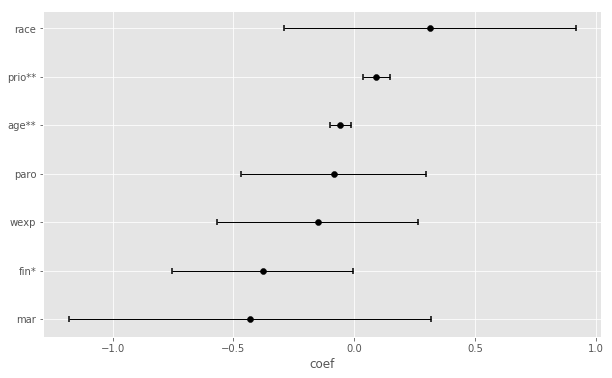

In [67]:
cph.plot()

#### Checking the proportional hazards assumption: log-log plot

PH assumption: curves are parallel (they do not cross each other), then it's likely the variable satisfies the assumption.

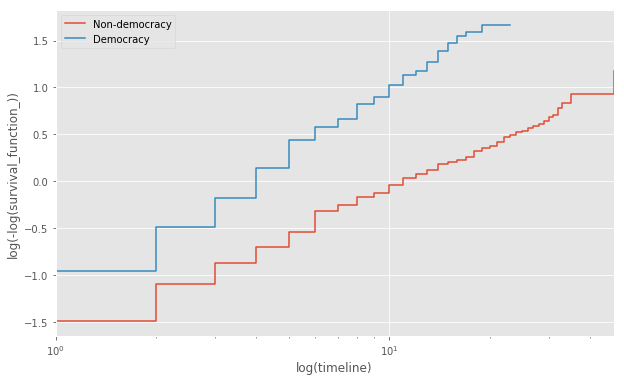

In [77]:
from lifelines.datasets import load_dd
from lifelines import KaplanMeierFitter

data = load_dd()

democracy_0 = data.loc[data['democracy'] == 'Non-democracy']
democracy_1 = data.loc[data['democracy'] == 'Democracy']

kmf0 = KaplanMeierFitter()
kmf0.fit(democracy_0['duration'], event_observed=democracy_0['observed'])

kmf1 = KaplanMeierFitter()
kmf1.fit(democracy_1['duration'], event_observed=democracy_1['observed'])

fig, axes = plt.subplots()
kmf0.plot_loglogs(ax=axes)
kmf1.plot_loglogs(ax=axes)

axes.legend(['Non-democracy', 'Democracy'])

plt.show()

#### Stratification

Sometimes a covariate may not obey the proportional hazard assumption. In this case, we can allow a factor to be adjusted for without estimating its effect.

In [78]:
cph.fit(rossi_dataset, 'week', event_col='arrest', strata=['race'])

cph.print_summary()  # access the results using cph.summary

n=432, number of events=114

        coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95    
fin  -0.3774     0.6856    0.1913 -1.9729 0.0485     -0.7524     -0.0024   *
age  -0.0573     0.9443    0.0220 -2.6076 0.0091     -0.1004     -0.0142  **
wexp -0.1435     0.8664    0.2127 -0.6746 0.4999     -0.5603      0.2734    
mar  -0.4418     0.6429    0.3819 -1.1569 0.2473     -1.1905      0.3069    
paro -0.0838     0.9196    0.1958 -0.4282 0.6685     -0.4677      0.3000    
prio  0.0919     1.0962    0.0287  3.1979 0.0014      0.0356      0.1482  **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.638


### Cox’s Time Varying Proportional Hazard model

We can incorporate changes over time into our survival analysis by using a modification of the Cox model above. The general mathematical description is:

$$
\lambda(t|X) = b_0(t)\ \exp\left(\sum_{i=1}^d\ b_i x_i(t)\right)
$$

Note the time-varying $x_i(t)$ to denote that covariates can change over time. This model is implemented in lifelines as `CoxTimeVaryingFitter`. The dataset schema required is different than previous models, so we will spend some time describing this.

Lifelines requires that the dataset be in what is called the *long* format.


We can use to_long_format to transform the base dataset into a long format and `add_covariate_to_timeline` to fold the covariate dataset into the original dataset.

In [79]:
from lifelines.utils import to_long_format
from lifelines.utils import add_covariate_to_timeline

base_df = to_long_format(base_df, duration_col="T")
df = add_covariate_to_timeline(base_df, cv, duration_col="time", id_col="id", event_col="event")

ImportError: cannot import name to_long_format